<h1>Resource Estimation: Electronic Structure (DPW)</h1>

<font size="3">

<hr>
DISTRIBUTION STATEMENT A. Approved for public release. Distribution is unlimited.

This material is based upon work supported by the Under Secretary of Defense for
Research and Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions,
findings, conclusions or recommendations expressed in this material are those of the
author(s) and do not necessarily reflect the views of the Under Secretary of Defense
for Research and Engineering.

© 2023 Massachusetts Institute of Technology.

The software/firmware is provided to you on an As-Is basis

Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part
252.227-7013 or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government
rights in this work are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed
above. Use of this work other than as specifically authorized by the U.S. Government
may violate any copyrights that exist in this work.
<hr><hr>
</font>

In [1]:
import cirq
import cirq_ft            as      cft
import numpy              as      np
import matplotlib.pyplot  as      plt
from scipy.optimize       import  curve_fit
from cirq.contrib.svg     import  SVGCircuit

from pyLIQTR.ProblemInstances.getInstance import *
from pyLIQTR.BlockEncodings.getEncoding   import *
from pyLIQTR.utils.resource_analysis          import estimate_resources
from pyLIQTR.utils.circuit_decomposition      import circuit_decompose_multi
from pyLIQTR.qubitization.qubitized_gates     import QubitizedWalkOperator
from pyLIQTR.utils.printing                 import openqasm

from pyLIQTR.pest_interface.pest_python import pw_to_dpw_cutoff


In [3]:
def get_walk_op_resources(hamfile,gridfile,energy_error=1e-3,control_val=1):
    slab = getInstance('ElectronicStructure', filenameH=hamfile, filenameG=gridfile)
    encoding = getEncoding(VALID_ENCODINGS.LinearT,instance = slab,energy_error=energy_error, control_val=control_val)
    registers = cft.infra.get_named_qubits(encoding.signature)
    walk_op = QubitizedWalkOperator(encoding)
    walk_circuit = cirq.Circuit(walk_op.on_registers(**registers))
    resources = estimate_resources(walk_circuit,profile=True)
    T_step = resources['T'] # T counts per walk operator
    N_logical = resources['LogicalQubits'] # number of logical qubits per walk operator
    N_sites = slab._N # number of real space grid points
    T_total = T_step/energy_error # total T gates needed for given energy_error
    return N_sites, N_logical, T_step, T_total

##### <u>References:</u>
[1] [Encoding Electronic Spectra in Quantum Circuits with Linear T Complexity](https://arxiv.org/abs/1805.03662)

<hr>
<h3><u>Introduction</u></h3>

This tutorial uses `pyLIQTR` to generate explicit resource estimates for ground state energy estimation (GSEE).  We focus on molecular systems and a fault-tolerant approach with $T$-gate complexity that scales linearly in problem size  (described in [[1]](https://arxiv.org/abs/1805.03662)).  In this case, the resource overhead is primarily determined by repetitions of a qubitized walk operator $W$:

<center><img src="./figures/qubitized_phase_estimation.png" width="850"></center>

The physics underlying these estimates is specified by a (real-space) dual plane-wave Hamiltonian $H$. To ease exposition, we provide reference Hamiltonians that were generated using the `PEST` module of `pyLIQTR`.  A target accuracy of $\epsilon = 1.0 \times 10^{-3}$ has been adopted for physical observables,  corresponding to millihartree precision in energy (or, equivalently, 0.027 eV which is a common target for chemical problems).

The walk operator $W$ is the same in all repetitions.  As such, we only have to construct a single explicit circuit for this element. Our implementation  is based on an implicit fermionic block encoding for $H$ that circumvents the need for a direct Pauli string representation ( this ultimately corresponds to the Jordan-Wigner procedure; see [[1]](https://arxiv.org/abs/1805.03662)). The end result is a marked reduction in overhead beyond a naive LCU based on individual Pauli string terms. This encoding appears in $W$ as a sequential series of $\text{Prepare} \cdot \text{Select} \cdot \text{Prepare}^{-1}$ oracles.  

<div class="alert alert-block alert-info"> 
<b>Generating Hamiltonians:</b> To understand how these Hamiltonians are generated, please see the `pest-intro.ipynb` notebook for an introduction to `PEST`.  The supplementary  `pest-python.ipynb` notebook describes how this Juila-based tool can be integrated alongside `pyLIQTR`.  Notably, the `PEST` code generates Hamiltonian coefficients for a physical system - specified as atomic coordinates and supercell parameters - and outputs these data as  HDF5 files.  This tool is intended to be flexible, giving coefficients in terms of either Fermionic operators  or an explicit Pauli-string LCU via the Jordan-Wigner transformation.</div>

<hr>
<h3><u>Resource Estimation: Inputs</u></h3>

Our resource analysis demo will follow the `PEST` results for a 4x4x2 Mg (0001) slab.  This is arranged for periodic electronic structure as follows:

<center><img src="./figures/figure-slab.png" width="850"></center>

<h4><b>Case I: Via Explicit Circuits</b></h4>


`pyLIQTR` provides a framework to construct explicit block encodings, via the `BlockEncoding` class, for both model Hamiltonians and their detailed electronic structure counterparts. The Hamiltonians are constructed as a `ProblemInstance`, which can then be encoded using one of the supported encodings. 

Since this notebook is concerned with resource estimation, we have provided DPW Hamiltonians for a 4x4x2 Mg (0001) surface (other precomputed systems are also found in the `data` directory).  These Hamiltonians span a range of equivalent plane-wave cutoffs (and hence increasingly fine real-space grids), which ultimately determine the number of basis functions and thus the problem size.  We can derive a scaling approach to resource estimates from this data.
 
The provided DPW data can be used directly to create an ElectronicStructure `ProblemInstance`. This, the subsequent encoding steps and walk operator generation are outlined below.

<b>First</b>, we create the `ProblemInstance` using the smallest Hamiltonian for a 4x4x2 Mg slab.

In [4]:
hamhdf5     =  f"../../../data/hamiltonians/mg_slab-4x4x2/magnesium-4x4x2-Ecut_0.5_scale_1.0.ham.hdf5"
gridhdf5    =  f"../../../data/hamiltonians/mg_slab-4x4x2/magnesium-4x4x2-Ecut_0.5_scale_1.0.grid.hdf5"

mg_slab = getInstance('ElectronicStructure', filenameH=hamhdf5, filenameG=gridhdf5)
print(mg_slab)

ElectronicStructure
	Hamiltonian filename:../../../data/hamiltonians/mg_slab-4x4x2/magnesium-4x4x2-Ecut_0.5_scale_1.0.ham.hdf5	Grid filename:../../../data/hamiltonians/mg_slab-4x4x2/magnesium-4x4x2-Ecut_0.5_scale_1.0.grid.hdf5
	N:36	M_vals:[3 3 4]


Here, M_vals corresponds to the number of real-space grid points along each dimension and N is the total number of basis functions (multiply by 2 for spin-orbitals).

<b>Next</b>, we encode the Hamiltonian using the algorithm from [[1]](https://arxiv.org/pdf/1805.03662.pdf) Section IV. This uses the `Fermionic_LinearT(BlockEncoding)` class in `pyLIQTR` and is easily accessed using the `getEncoding` function. The LinearT encoding uses two parameters: \
`energy_error` - the desired accuracy of the estimated energy spectra (denoted $\epsilon$ above) in the same units as the Hamiltonian coefficients (Hartree)\
`control_val`  - the value the Select oracle is controlled on

The encoding will use the `energy_error` input to determine `approx_error`, which is the precision to which the Hamiltonian coefficients will be prepared. This is based on the conditions indicated in [[1]](https://arxiv.org/pdf/1805.03662.pdf) Eqs. (35) and (36). Alternatively, the user can pass the desired value of approx_error as a keyword argument and omit the energy_error value.

In [5]:
energy_error = 1e-3 # Hartree units
mg_slab_LinearTEncoding = getEncoding(VALID_ENCODINGS.LinearT,instance = mg_slab, energy_error=energy_error, control_val=1)
print(f"approx_error={mg_slab_LinearTEncoding.approx_error}")

approx_error=4.4e-09


The encoding provides access to the registers it acts on as well as the encoding circuit as seen below.

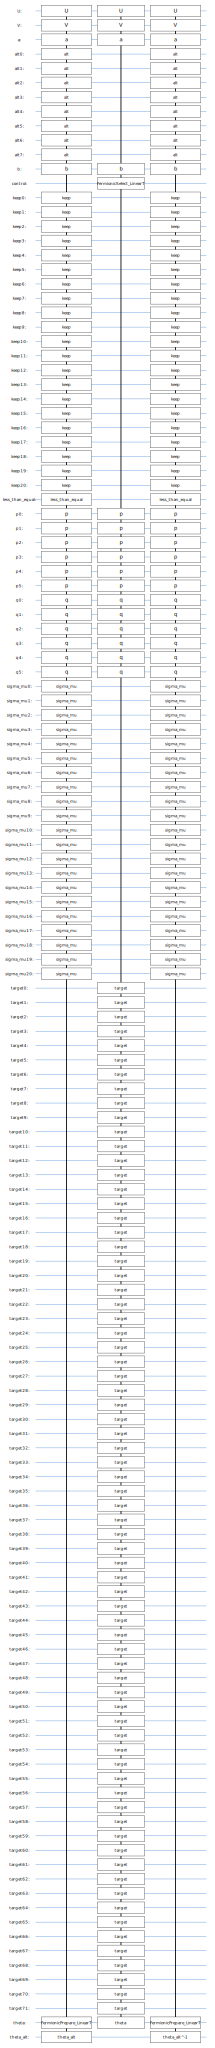

In [6]:
registers = cft.infra.get_named_qubits(mg_slab_LinearTEncoding.signature)
mg_slab_operator = mg_slab_LinearTEncoding.on_registers(**registers)
mg_slab_encoding_circuit = mg_slab_LinearTEncoding.circuit
SVGCircuit(circuit_decompose_multi(mg_slab_encoding_circuit,1))

The encoding can be passed directly to the `QubitizedWalkOperator` with the corresponding circuit shown below.

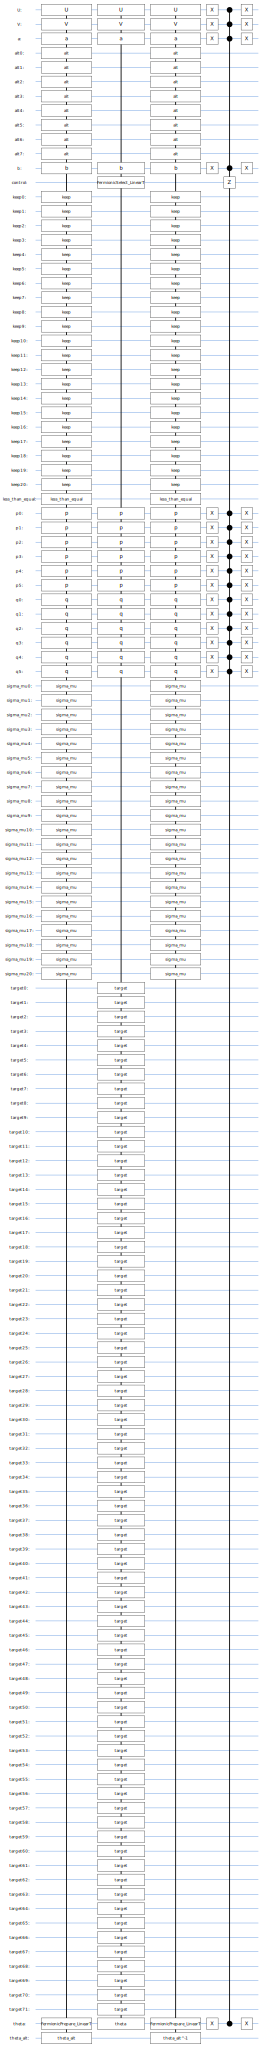

In [7]:
walk_op = QubitizedWalkOperator(mg_slab_LinearTEncoding,multi_control_val=0)
walk_circuit = cirq.Circuit(walk_op.on_registers(**registers))
SVGCircuit(circuit_decompose_multi(walk_circuit,2))

---
#### LIQTR Like 👍 : Circuit Decomposition
---
`cirq` / `cirq-ft` provide the ability to decompose circuits/operators into their constituent parts (ie, a QSVT sequence is a cosine and then sine sequence). Different circuits will have different levels of decomposition, since they are composed of different operators. 

We generally think of a "level 0" decomposition as being the original circuit, a "level N-1" decomposition being a circuit level that includes non-clifford+T gates, and a "level N" decomposition as the level that consists of just the valid gate set for the architcture (ie clifford+T).

The following lines show some of the supported levels of decompositions:

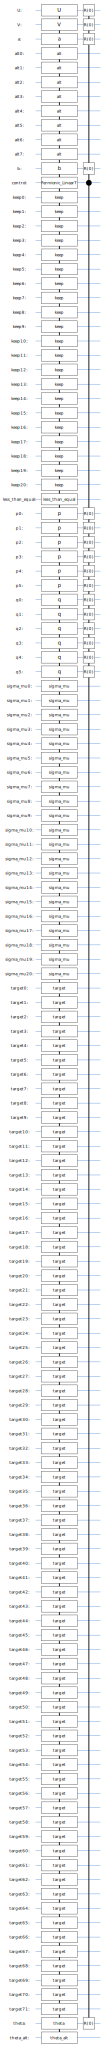

In [7]:
SVGCircuit(circuit_decompose_multi(walk_circuit,1))

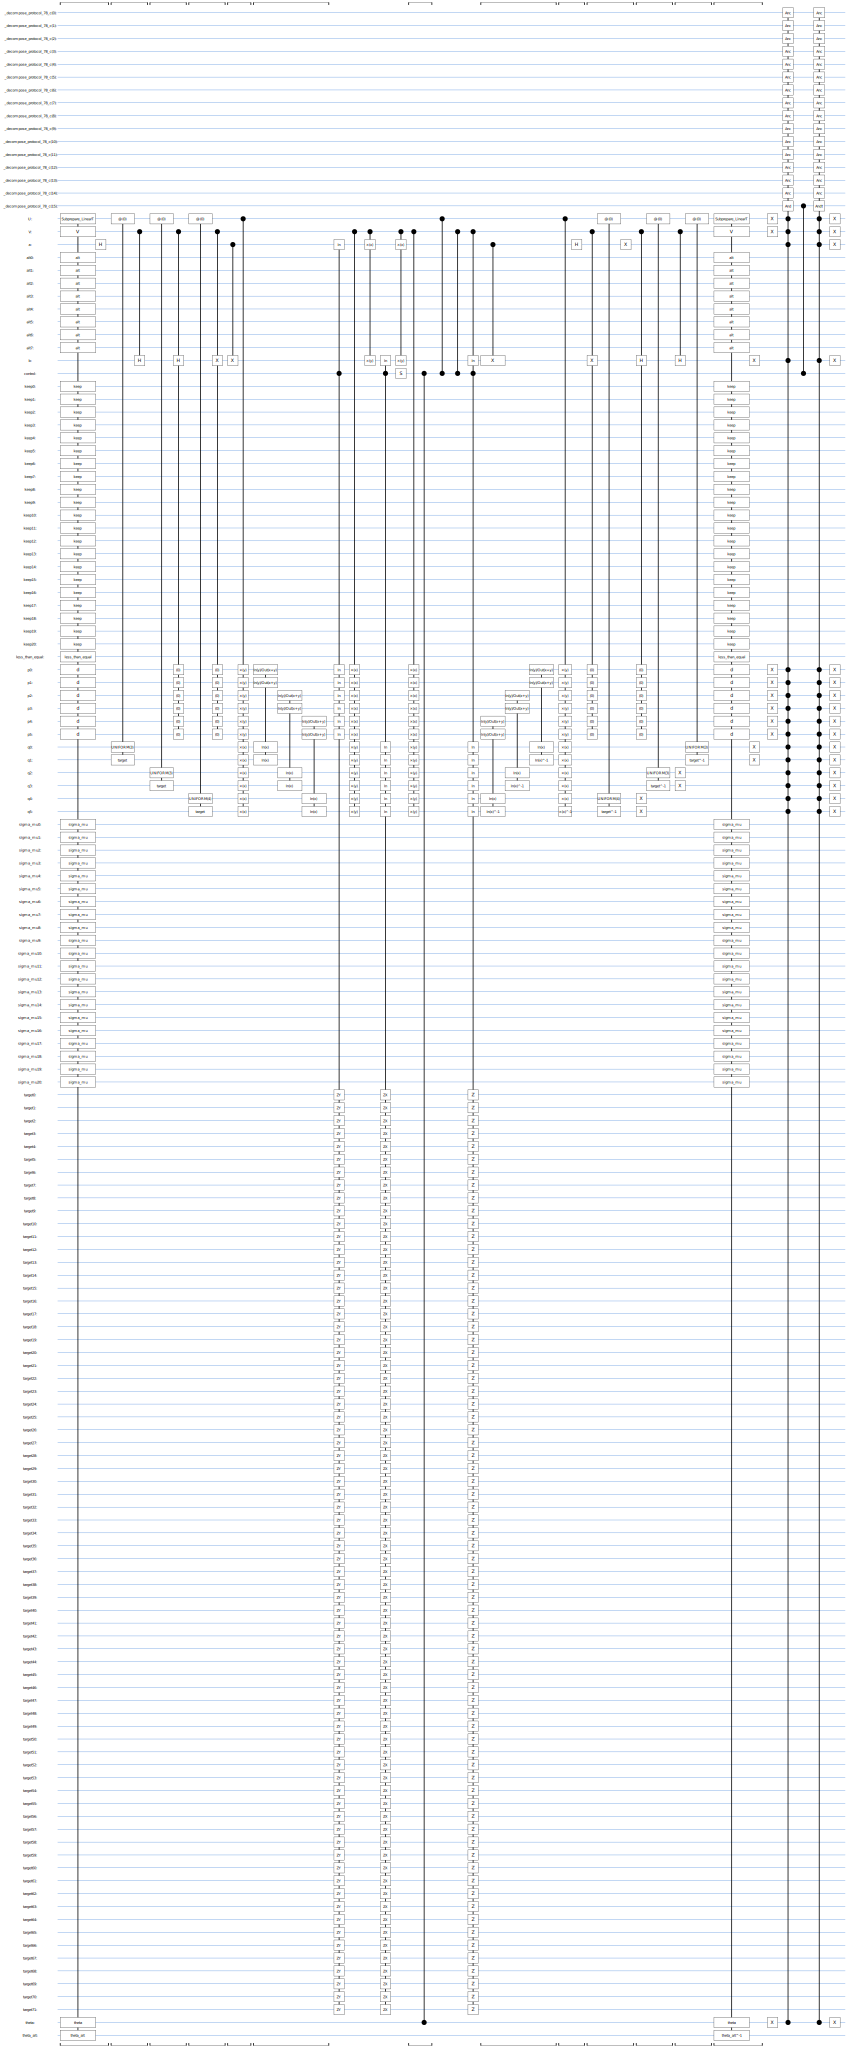

In [8]:
SVGCircuit(circuit_decompose_multi(walk_circuit,3))

---

<b>Finally</b>, the resources can be estimated directly from the circuit using `estimate_resources`. While the final resource estimates depend on the precision needed for rotation gates, *here we look at the resources <b>BEFORE</b> rotation gate synthesis*. This is so we can later compare to the analytic complexity from Ref [[1]](https://arxiv.org/abs/1805.03662), which does not include the additional gate counts from rotation gates. We do this by setting `profile=True`.

In [8]:
resource_estimate = estimate_resources(walk_circuit,profile=True)
print(resource_estimate)

{'LogicalQubits': 142, 'T': 4788, 'Clifford': 23418, 'Rotations': 1348}


The function `get_walk_op_resources` steps through the process outlined above. Below, we use it to tabulate the resources for magnesium slabs of increasing energy cutoffs.

In [9]:
## Target GSEE precision
##
eps        =  1.0e-3


## Parameters specifying which Hamiltonians to load.
##
E_cutoffs  =  [0.5,1.0,2.5,5.0]

scale      =  1.0

numEC      =  len(E_cutoffs)

N_sites, N_logical, T_step, T_total = (np.zeros(numEC) for _ in range(4))

## Load basis grids and DPW Hamiltonian coefficients; estimate resources
## for qubitized GSEE to precision of <eps>
##
for i, EC in enumerate(E_cutoffs):

    hamhdf5     =  f"../../../data/hamiltonians/mg_slab-4x4x2/magnesium-4x4x2-Ecut_{str(EC)}_scale_{str(scale)}.ham.hdf5"
    gridhdf5    =  f"../../../data/hamiltonians/mg_slab-4x4x2/magnesium-4x4x2-Ecut_{str(EC)}_scale_{str(scale)}.grid.hdf5"

    N_sites[i], N_logical[i], T_step[i], T_total[i] = get_walk_op_resources(hamhdf5,gridhdf5,energy_error=eps)

print(f"N_sites: {np.array2string(N_sites, separator=',')}")
print(f"N_logical: {np.array2string(N_logical, separator=',')}")
print(f"T_step: {np.array2string(T_step, separator=',')}")
print(f"T_total: {np.array2string(T_total, separator=',')}")

N_sites: [ 36., 80.,336.,792.]
N_logical: [ 142., 235., 757.,1681.]
T_step: [ 4788., 7862.,25786.,56622.]
T_total: [ 4788000., 7862000.,25786000.,56622000.]


---
#### LIQTR Like 👍 : Resource Analysis
---
Resource analysis of `cirq` circuits can be done by using the `pyLIQTR.utils.resource_analysis.estimate_resources` function, which will provide T, qubit, and Clifford counts for most circuits!

Note that our estimate for T-count is done via experimentally derived statistical distribution for the Clifford count of rotations at a given precision. This can be passed explicitly using the `rotation_gate_precision` (default 1e-10) keyword argument, or can be implicitly calculated by passing the `circuit_precision`. If no precision argument is provided, a default value will be used.

In [11]:
resource_estimate = estimate_resources(walk_circuit,circuit_precision=1e-3)
print(resource_estimate)

{'LogicalQubits': 142, 'T': 91060, 'Clifford': 195963}


---
#### LIQTR Like 👍 : Export of circuits to OpenQASM
---
Export of circuits can be done using a provided `pyLIQTR` utility (`pyLIQTR.utils.printing.openqasm`) that wraps `cirq`'s native openQASM export. This is introduced since some new cirq-ft operators do not yet have a decomposition in terms of gates defined, or `cirq` has begun to use features (mid-circuit measurement, classical control, etc) not supported by OpenQASM2.

This utility fully decomposes circuits to either include rotation gates (`rotation_allowed=True`) or not (`rotation_allowed=False`). 

In the latter case, we make use a of a Clifford+T representation outlined in https://arxiv.org/pdf/0806.3834.pdf (and further discussed in https://arxiv.org/pdf/1312.6584.pdf and http://www.cs.umd.edu/~amchilds/qa/qa.pdf, as potentially easier to digest forms).

When `rotation_allowed=False`, we introduce the "rx_d/ry_d/rz_d gate", followed by a line of the form:
```
// (leading_T, gate_sequence, sequence_length, clifford_part)
```
* `leading_T` : A bool indicating whether or not there is a `T` gate at the start of the sequence
* `gate_sequence`: An int whose binary representation encodes a sequence of `H`, `S`, and `T` gates
* `sequence_length`: The number of `T` gates in the sequence (note if `leading_T` is true, the total number of gates is `sequence_length+1`)
* `clifford_part`: A List[str] of clifford gates that come at the end of the H,S,T sequence.

Note that when `rotation_allowed=False`, you may also want to specify a level of precision by passing `gate_precision` or `circuit_precision` to `pyLIQTR.utils.printing.openqasm`

In [10]:
greedy_mm = cirq.GreedyQubitManager(prefix="_ancilla", maximize_reuse=False)
context = cirq.DecompositionContext(greedy_mm)
for ctr,line in enumerate(openqasm(walk_circuit,rotation_allowed=True,context=context)):
    print(line)
    if ctr > 100:
        break

// Generated from Cirq, Openfermion, and MIT LL

OPENQASM 2.0;
include "qelib1.inc";

// Qubits: [U, V, _ancilla_0, _ancilla_1, _ancilla_2, _ancilla_3, _ancilla_4, _ancilla_5, _ancilla_6, _ancilla_7, _ancilla_8, _ancilla_9, _ancilla_10, _ancilla_11, _ancilla_12, _ancilla_13, _ancilla_14, _ancilla_15, _ancilla_16, _ancilla_17, _ancilla_18, _ancilla_19, _ancilla_20, _ancilla_21, _ancilla_22, _ancilla_23, _ancilla_24, _ancilla_25, _ancilla_26, _ancilla_27, _ancilla_28, _ancilla_29, _ancilla_30, _ancilla_31, _ancilla_32, _ancilla_33, _ancilla_34, _ancilla_35, _ancilla_36, _ancilla_37, _ancilla_38, _ancilla_39, _ancilla_40, _ancilla_41, _ancilla_42, _ancilla_43, _ancilla_44, _ancilla_45, _ancilla_46, _ancilla_47, _ancilla_48, _ancilla_49, _ancilla_50, _ancilla_51, _ancilla_52, _ancilla_53, _ancilla_54, _ancilla_55, _ancilla_56, _ancilla_57, _ancilla_58, _ancilla_59, _ancilla_60, _ancilla_61, _ancilla_62, _ancilla_63, _ancilla_64, _ancilla_65, _ancilla_66, _ancilla_67, _ancilla_68, _ancilla_

---

<h4><b>Case II: Precomputed Counts</b></h4>

The pre-computed data below can be used in lieu of evaluating the cells above. Note that this extends to a larger problem scale, which would have a commensurate increase in runtime. These resource counts are before rotation gate synthesis. 


In [25]:
## Energy Precision in Hartree
##
eps = 1.0e-3 

## Hamiltonian coefficient preparation precision
##
approx_errors = np.array([2.0e-09,5.9e-11,6.3e-12,5.8e-13,2.6e-14,9.5e-15,3.6e-15,3.4e-16])

## Real-space (DPW) lattice sites (multipy by two for spin orbitals)
## 
N_sites     =  np.array([80., 336., 792., 2145., 5940., 8160., 10868., 28860.])         

## Total logical qubits
##
N_logical   =  np.array([235., 757., 1677., 4390., 11994., 16439., 21855., 57846.])

## T-count per step
##
T_step      =  np.array([7862., 25786., 56598., 146752., 396492., 540774., 716798., 1868608.])

## Total T-count
##
T_total     =  np.array([7.862000e+06, 2.578600e+07, 5.659800e+07, 1.467520e+08,3.964920e+08, 5.407740e+08, 7.167980e+08, 1.868608e+09])


<hr>
<h3><u>Resource Estimation: Fitting</u></h3>

We can obtain estimates for larger systems by fitting and scaling our explicit overhead values.  The following sections implement the required fits over the domain specified below:

In [12]:
N_so        = 2*N_sites
N_domain    =  np.linspace(N_so[0], N_so[-1], 25)

<h5><b>Fit: Logical Qubits</b></h5>

Logical qubits counts should scale as $N_{so} + \log (4\sqrt{2} \pi \lambda^3 N_{so}^5 / \epsilon^3) + O(1)$, where $N_{so}$ is the number of spin-orbitals, $\lambda$ is the Hamiltonian normalization, and  $\epsilon$ is energy precision. This comes from Eq.(55) of [[1]](https://arxiv.org/abs/1805.03662).

In [13]:
ES_func_N_logical = lambda N,a,lb3 : N + a*np.log2(lb3 * N**5 / eps**3)
ES_fit_params_N_logical, pcov = curve_fit(ES_func_N_logical, N_so, N_logical, bounds=(0.0,100.0))

fit_func_N_logical = lambda N : ES_func_N_logical(N,*ES_fit_params_N_logical)

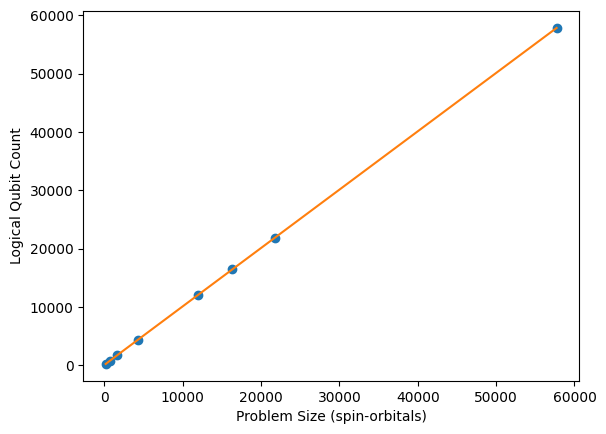

In [14]:
plt.plot(N_so,N_logical,'o',N_domain,fit_func_N_logical(N_domain))
plt.xlabel('Problem Size (spin-orbitals)');
plt.ylabel('Logical Qubit Count');

<h5><b>Fit: Total T-Count</b></h5>

An approximate $T$-count scaling for qubitized GSEE (DPW electronic structure) is given by $24\sqrt{2} \pi \lambda N_{so} / \epsilon + O((\lambda/\epsilon) \log(N_{so}/\epsilon))$ where $N_{so}$ is spin-orbital number, $\lambda$ is the Hamiltonian normalization, and  $\epsilon$ is energy precision. This comes from Theorem 1 of Ref [[1]](https://arxiv.org/abs/1805.03662). We again note that the below data is for resource estimates *before* rotation gate synthesis.

In [26]:

ES_func_T_total = lambda N,a,b,c : a*(24*np.sqrt(2)*np.pi)*N/eps + b*(1/eps)*np.log(N/eps) + c
ES_fit_params_T_total, pcov = curve_fit(ES_func_T_total, N_so, T_total)

fit_func_T_total = lambda N : ES_func_T_total(N,*ES_fit_params_T_total)


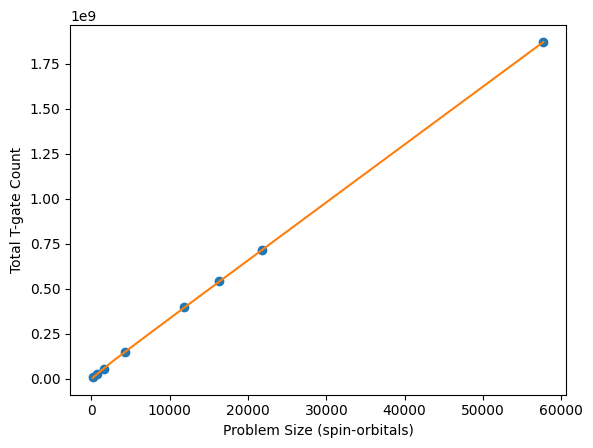

In [27]:
plt.plot(N_so,T_total,'o',N_domain,fit_func_T_total(N_domain))
plt.xlabel('Problem Size (spin-orbitals)');
plt.ylabel('Total T-gate Count');

<hr>
<h3><u>Cutoff / Grid Determination</u></h3>




The dual plane-wave (DPW) scheme is a formal, real-space dual to "pure" plane-wave basis sets (PWs).  This is actually a complication, since pure PWs  require extremely high kinetic energy cutoffs for realistic calculations (up to the $10^6$ Rydberg scale).  These high cutoffs correspond to extremely short DPW grid spacings and thus very large real-space bases.  

Physically, the  high-frequency PW modes are used to reconstruct rapid wavefunction oscillations near atomic nuclei (the so-called "nuclear cusp"). Fortunately, these oscillations are generally tied to (often) irrelevant core electrons. Classical calculations mitigate this by  using  so-called pseudopotentials (PPs) to smooth the nuclear potential, leading to markedly lower energy cutoffs and smaller basis sets.  While  pseudopotentials for DPWs have not been explicitly constructed, they are formally obtained by taking the Fourier transform of a PW basis.  Based on this, we will assume that a suitable DPW basis can be developed for a given chemically / physically relevant plane-wave pseudopotential.


Since plane-wave calculations widely used for classical electronic structure (DFT, etc.), we can often adopt a validated cutoff energy.  In the context of ultrasoft pseudopotentials, we can define a low- and high-resolution bases as having kinetic cutoffs of $E_c = 30$ Ry and $E_c = 60$ Ry respectively, (note that higher cutoffs are needed for light atoms like hydrogen, etc.).  This maps to a real-space lattice constant via $a_0 = \gamma \sqrt{2 \pi^2 / E_c}$, where we assume atomic units, i.e., $a_0$ measured in Bohr radii and $E_c$ in Hartree (1 Ry = 2 Ha).  Setting the constant $\gamma = 1.0$ will place grid points at the highest PW wavelength, while $\gamma = 0.5$ will apply these every half-wavelength. These considerations can become quite nuanced, as  we discuss at the end of this notebook.
 
 The DPW grid spacing corresponding to a given plane wave  is calculated using the `pw_to_dpw_cutoff` function.


In [28]:
scale         =  1.0            # sampling scale vs. wavelength

In [29]:
E_cut         =  30

a0_30ry_bohr = pw_to_dpw_cutoff(E_cut,node_scale=scale)
a0_30ry_angstrom = pw_to_dpw_cutoff(E_cut,node_scale=scale,unit="angstrom")

print("Grid spacing for "+str(E_cut)+" Ry (Bohr):\t\t",a0_30ry_bohr)
print("Grid spacing for "+str(E_cut)+" Ry (Angstrom):\t",a0_30ry_angstrom)

Grid spacing for 30 Ry (Bohr):		 1.1471474419090952
Grid spacing for 30 Ry (Angstrom):	 0.6070440418671293


In [30]:
E_cut = 60

a0_60ry_bohr = pw_to_dpw_cutoff(E_cut,node_scale=scale)
a0_60ry_angstrom = pw_to_dpw_cutoff(E_cut,node_scale=scale,unit="angstrom")

print("Grid spacing for "+str(E_cut)+" Ry (Bohr):\t\t",a0_60ry_bohr)
print("Grid spacing for "+str(E_cut)+" Ry (Angstrom):\t",a0_60ry_angstrom)

Grid spacing for 60 Ry (Bohr):		 0.8111557351947223
Grid spacing for 60 Ry (Angstrom):	 0.42924495848313754


In [31]:
E_cut = 100

a0_100ry_bohr = pw_to_dpw_cutoff(E_cut,node_scale=scale)
a0_100ry_angstrom = pw_to_dpw_cutoff(E_cut,node_scale=scale,unit="angstrom")

print("Grid spacing for "+str(E_cut)+" Ry (Bohr):\t\t",a0_100ry_bohr)
print("Grid spacing for "+str(E_cut)+" Ry (Angstrom):\t",a0_100ry_angstrom)

Grid spacing for 100 Ry (Bohr):		 0.6283185307179586
Grid spacing for 100 Ry (Angstrom):	 0.3324917151297372


<hr>
<h3><u>Resource Estimation: Extrapolation<u></h3>

<h5><b>Mg Anticorrosive Coating: 4x4x2 </b></h5>

The leading  overhead in DPW-based GSEE comes from the electron-electron terms.  These are fixed by the size of the unit cell and the DPW basis grid spacing, and independent of the specific atoms in the system.  We can extract such an estimate by using the precomputed overhead values above.  However, the electron-ion interaction terms also contribute to the $T$-count. An estimate that includes all of these terms can be obtained by using the explicit Hamiltonians above.

The supercell vectors for an orthorhombic 4x4x2 Mg (0001) slab with full periodicity (i.e., a vacuum gap between images normal to the surface) are:


In [32]:
v1  =  12.83708
v2  =  11.11724
v3  =  15.631000

# The same for an 8x8x2 cell
#
# v1  =  12.83708   *  2.0
# v2  =  11.11724   *  2.0
# v3  =  15.631000  

# The same for a 16x16x2 cell
#
v1  =  12.83708   *  4.0
v2  =  11.11724   *  4.0
v3  =  15.631000  

These lengths contain the padding that is required between periodic images (if not we would add it using `pad=`):

In [33]:
pad    =  0.0

v_vec  =  np.array([v1+pad,v2+pad,v3+pad])

print("Cell Dimensions:\t",v_vec)
print("Cell Volume:\t\t", np.prod(v_vec))

Cell Dimensions:	 [51.34832 44.46896 15.631  ]
Cell Volume:		 35691.92525312889


We can obtain the number of DPW basis functions in this cell by assuming an equivalent plane-wave cutoff energy of $E_c = 60$ Ry:

In [34]:
#N_per_angstrom  =  1.0/a0_30ry_angstrom                 
N_per_angstrom  =  1.0/a0_60ry_angstrom                 
#N_per_angstrom  =  1.0/a0_100ry_angstrom                 


N_grid          =  np.ceil(v_vec*N_per_angstrom)
N_grid_total    =  int(np.prod(N_grid))

print("Real-Space Grid Points / Angstrom:\t", N_per_angstrom)
print()
print("Real-Space Grid Dimensions:\t\t", N_grid)
print("Total Real-Space Basis Functions:\t", N_grid_total)

Real-Space Grid Points / Angstrom:	 2.329672091045151

Real-Space Grid Dimensions:		 [120. 104.  37.]
Total Real-Space Basis Functions:	 461760


This gives the number of grid points and thus our problem scale.  The scaling relations above can then be used to estimate the logical algorithmic overhead:

In [35]:
N_so_total = 2*N_grid_total

mg_slab_T_total    =  fit_func_T_total(N_so_total)

mg_slab_N_logical  =  int(np.ceil(fit_func_N_logical(N_so_total)))

print("Total T-Gate Count:\t\t", "{:e}".format(mg_slab_T_total) )
print()
print("Total Logical Qubit Count:\t", mg_slab_N_logical)


Total T-Gate Count:		 2.961444e+10

Total Logical Qubit Count:	 923676


<hr>
<h3><u>Cautionary Note: What is an equivalent real-space grid?<u></h3>

The parameter `node_scale` reflects the rescaling factor $\gamma$ for the DPW grid spacing.  While the quantity itself is simplistic, the rationale for its selection can become quite nuanced. For instance, a value of`node_scale=1.0` will set the grid spacing equal to the wavelength of the  highest-energy PW component.  Using this value rimplies that the highest-frequency plane-wave modes would be  "aliased" in a sense (consider the Nyquist argument that one should sample at $\ell \leq \lambda/2$ to capture some signal).  This implies that we should set `node_scale=0.5` to ensure that we will always get an equivalent DPW basis, right?  
 
The correct answer is more nuanced, largely because we are making assumptions about real-space pseudopotential methods that have not been formally constructed.  In fact, estimates using a "coarser" DPW basis might not be as mismatched as one might think.  Part of this is by construction $-$ a practical real-space basis might assume a different functional than these direct DPWs.  In addition, the  highest-frequency plane-wave modes are used to construct local spatial  features that are poorly accommodated in a nonlocal basis. A judicious real-space might better reproduce local features, at the cost of their nonlocal counterparts.  These formulation-dependent aspects are particularly apparent if we look at classical plane-wave methods, in that different pseudopotentials can give  similar resolution (for specific systems) with cutoffs that can differ by almost an order of magnitude.

A final appeal  comes from the unique nature of quantum methods.  An explicitly correlated quantum algorithm is likely to  give decisive insight for many problems, even when the basis set resolution is a bit lower.  The reason for this is simple $-$ we can access behaviors that are beyond the scope of classical hardware.  Of course, using a value like `node_scale=0.5` will invariably give better quantitative resolution.  This, however, comes with a roughly eightfold increase in $T$-count and logical qubits, which must be weighed against the intrinsic gain from a good description of correlation.

Taking all of these points into account, the parameter `node_scale` is a useful means to make an "educated" interpolation between different computational scales.